In [8]:
import cv2 as cv
import numpy as np


def select_chessboard_images_from_video(video_path, wait_msec=10, wnd_name='Frame with Chessboard'):
    # 비디오 파일 열기
    video = cv.VideoCapture(video_path)
    
    if not video.isOpened():
        print(f"Error opening video file: {video_path}")
        return []

    selected_images = []
    
    print("Press SPACE to start detecting chessboard patterns. Press ENTER to select images, ESC to finish.")

    while video.isOpened():
        ret, frame = video.read()
        
        if not ret:
            print("End of video or error in reading frame.")
            break
        
        gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

        display = frame.copy()
        cv.putText(display, f'NSelect: {len(selected_images)}', (10,25), cv.FONT_HERSHEY_DUPLEX, 0.6, (0, 255, 0))
        cv.imshow(wnd_name, display)

        key = cv.waitKey(wait_msec)
        # 스페이스바 입력 시 체스보드 탐지 시작
        if key == ord(' '):
            print("Chessboard detection started. Press ENTER to select images, ESC to finish.")

            # 체스보드 코너 탐지
            complete, corners = cv.findChessboardCorners(gray, chessboard_size)

            if complete:  # 체스보드가 성공적으로 감지된 경우
                # 코너 위치를 개선
                corners = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), 
                                          (cv.TermCriteria_EPS + cv.TermCriteria_MAX_ITER, 30, 0.001))
                
                # 체스보드 코너를 프레임에 그려서 확인
                frame_with_corners = cv.drawChessboardCorners(frame, chessboard_size, corners, complete)
                cv.imshow(wnd_name, frame_with_corners)
                
                # 다시 키 입력 대기 (Enter 또는 다른 키 처리)
                key = cv.waitKey()

                # Enter (ASCII 13) 입력 시 이미지 선택
                if key == 13 or key == 10:  # Enter는 OS에 따라 13(\r) 또는 10(\n)
                    selected_images.append(frame_with_corners)
                    print(f"Selected {len(selected_images)} image(s)")
            else:
                print("Chessboard not detected in this frame. Try again.")

        # ESC 키 입력 시 종료
        if key == 27:  # ESC 키의 ASCII 코드 값
            print("Exiting image selection.")
            break

    # 비디오와 윈도우 닫기
    video.release()
    cv.destroyAllWindows()
    
    return selected_images


In [9]:
import cv2 as cv
import numpy as np

def calibrate_camera_from_images(selected_images, chessboard_size):
    # 3D 좌표를 저장할 리스트 (체스보드 코너의 3D 좌표)
    obj_points = []
    
    # 2D 이미지 좌표를 저장할 리스트 (이미지에서 체스보드 코너의 2D 좌표)
    img_points = []

    # 체스보드의 각 코너에 대응하는 3D 좌표를 생성 (z = 0인 평면)
    obj_p = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
    obj_p[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)

    for image in selected_images:
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        
        # 체스보드 코너 찾기
        ret, corners = cv.findChessboardCorners(gray, chessboard_size, None)
        
        if ret:
            # 코너 위치를 더 정확하게 찾기 위해 조정
            corners_refined = cv.cornerSubPix(
                gray, corners, (11, 11), (-1, -1),
                (cv.TermCriteria_EPS + cv.TermCriteria_MAX_ITER, 30, 0.001)
            )
            
            # 2D 이미지 좌표 저장
            img_points.append(corners_refined)
            
            # 대응하는 3D 좌표 저장
            obj_points.append(obj_p)

    # 카메라 보정을 수행하여 카메라 매트릭스, 왜곡 계수, 회전 벡터, 변환 벡터 계산
    ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv.calibrateCamera(
        obj_points, img_points, gray.shape[::-1], None, None
    )

    # RMS 에러 계산 (루트 평균 제곱 오차)
    total_error = 0
    for i in range(len(obj_points)):
        img_points2, _ = cv.projectPoints(obj_points[i], rvecs[i], tvecs[i], camera_matrix, dist_coeffs)
        error = cv.norm(img_points[i], img_points2, cv.NORM_L2) / len(img_points2)
        total_error += error

    mean_error = total_error / len(obj_points)
    
    print(f"RMS Error: {mean_error}")
    print(f"Camera Matrix (K):\n{camera_matrix}")
    print(f"Distortion Coefficients:\n{dist_coeffs}")
    
    # RMS 에러, 카메라 매트릭스, 왜곡 계수, 회전 벡터, 변환 벡터 반환
    return mean_error, camera_matrix, dist_coeffs, rvecs, tvecs


In [10]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def undistort_and_display_image(image, camera_matrix, dist_coeffs):
    # 왜곡 제거된 이미지 생성
    undistorted_img = cv.undistort(image, camera_matrix, dist_coeffs)

    # 원본 이미지와 왜곡 제거된 이미지 출력
    cv.imshow("Original Image", image)
    cv.imshow("Undistorted Image", undistorted_img)
    cv.waitKey(0)
    cv.destroyAllWindows()

def visualize_camera_positions(rvecs, tvecs):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # 카메라 위치를 저장할 리스트
    camera_positions = []

    for rvec, tvec in zip(rvecs, tvecs):
        # 회전 벡터를 회전 행렬로 변환
        R, _ = cv.Rodrigues(rvec)
        
        # 카메라의 위치는 변환 벡터의 반대 방향 (카메라 좌표계에서 월드 좌표계로 변환)
        camera_position = -R.T @ tvec
        camera_positions.append(camera_position)

        # 카메라 위치 플로팅
        ax.scatter(camera_position[0], camera_position[1], camera_position[2], color='b')
    
    # 카메라 위치 시각화
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_title('Camera Positions in 3D Space')
    plt.show()

# 보정된 카메라 매트릭스, 왜곡 계수, 회전 및 변환 벡터들로부터 결과 출력
def process_calibration_results(selected_images, camera_matrix, dist_coeffs, rvecs, tvecs):
    if selected_images:
        # 왜곡 제거된 첫 번째 이미지 출력
        undistort_and_display_image(selected_images[0], camera_matrix, dist_coeffs)

    # 카메라 위치 시각화
    visualize_camera_positions(rvecs, tvecs)
    


Press SPACE to start detecting chessboard patterns. Press ENTER to select images, ESC to finish.
Chessboard detection started. Press ENTER to select images, ESC to finish.
Selected 1 image(s)
Chessboard detection started. Press ENTER to select images, ESC to finish.
Selected 2 image(s)
Chessboard detection started. Press ENTER to select images, ESC to finish.
Selected 3 image(s)
Chessboard detection started. Press ENTER to select images, ESC to finish.
Selected 4 image(s)
Chessboard detection started. Press ENTER to select images, ESC to finish.
Selected 5 image(s)
Chessboard detection started. Press ENTER to select images, ESC to finish.
Chessboard not detected in this frame. Try again.
Chessboard detection started. Press ENTER to select images, ESC to finish.
Selected 6 image(s)
Chessboard detection started. Press ENTER to select images, ESC to finish.
Selected 7 image(s)
Chessboard detection started. Press ENTER to select images, ESC to finish.
Selected 8 image(s)
Chessboard detecti

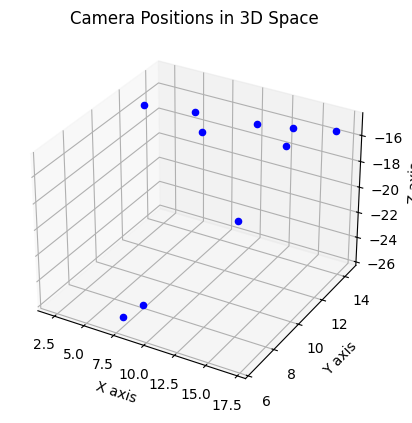

Final RMS Error: 0.13358421334764842
Final Camera Matrix:
[[1.69217262e+03 0.00000000e+00 9.65088454e+02]
 [0.00000000e+00 1.70261875e+03 4.96882343e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coefficients:
[[ 1.64652488e-01 -1.33492254e-01 -1.56059131e-02  3.38057718e-04
  -7.55219459e-01]]


In [11]:
# 체스보드 크기 설정 (10x7 패턴)
chessboard_size = (10, 7)
# 비디오 경로 설정 
video_path = 'C:/Users/kimin/cv-project/my-cv-project/camera_calibration/IMG_5303.MOV'
# 함수 호출하여 체스보드 이미지 선택
selected_images = select_chessboard_images_from_video(video_path)
# camera calibration
rms_error, camera_matrix, dist_coeffs, rvecs, tvecs = calibrate_camera_from_images(selected_images, chessboard_size)

# 왜곡 제거된 이미지와 카메라 위치 시각화
process_calibration_results(selected_images, camera_matrix, dist_coeffs, rvecs, tvecs)

print(f"Final RMS Error: {rms_error}")
print(f"Final Camera Matrix:\n{camera_matrix}")
print(f"Distortion Coefficients:\n{dist_coeffs}")